 # Introduction
This notebook describes an approach to classify movies as either comedies or dramas based on plot synopsis.  As such, it attempts to solve a typical text classification problem, albeit perhaps a tricky one, since defining humor can be difficult even for humans..  Classifications and synopses are taken from Wikipedia;  supplemental training data is taken from the news category dataset, which contains headlines and short descriptions of Huffington Post articles, in addition to categories that include comedy.  I apply a simple Bag-of-Words approach, a CNN-based approach, and a hybrid CNN-LSTM approach to the problem.  I also use a few standard text-processing steps to pre-processing the data.  The simplest approach turns out to be the best; none of the more complicated approaches I tried outperformed the Bag-of-Words logistic regression model.  

### Outline

1. Import and define tools and functions.
2.  Exploratory data analysis
3.  Text processing and vectorization.
4.  Bag-Of-Words Model
5.  GloVE Embeddings
6.  CNN Model
7.  CNN-LSTM Model
8.  Analysis and Conclusion

> "**Humor is kind of like pornography … you know it when you see it.**" -Kevin Litman Navarro

# 1. Import Tools****

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib
import json
import nltk
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Conv1D,MaxPooling1D,Dense,Flatten, Dropout
from keras.layers import Conv1D,MaxPooling1D,Dense,Flatten, Dropout, Bidirectional
from keras.layers import LSTM, Dropout,Activation, Bidirectional

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.stem.porter import *
import random
import copy

Using TensorFlow backend.


In [2]:
def removeStopWords(lowerArg):
    i=0
    removed=[]
    for x in lowerArg:
        i+=1
        removed.append((' '.join([word for word in x.split() if word not in nltk.corpus.stopwords.words('english')])))
        
    return pd.Series(removed).astype(str)

In [3]:
df=pd.read_csv('../input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv')
newsDF=pd.read_json('../input/news-category-dataset/News_Category_Dataset_v2.json', lines=True,dtype='str')

# 2. EDA for Movie Data
Quick initial look at the dataset.  Additional analysis (like counting unique words) will occur during processing and vectorization

In [4]:
##Limit to just comedies and Genres
genres=['drama','comedy']
df=df[df['Genre'].isin(genres)]
df=df.reset_index()
df['GenreID']=df['Genre'].apply(lambda x: genres.index(x))

wordCount=df['Plot'].apply(lambda x: x.count(' '))
print("Mean number of words in synopses: ",int(wordCount.mean()))
print("Standard deviation number of words in synopses: ", int(wordCount.std()))
print('Number of Dramas: ',df['Genre'].value_counts()[0])
print('Number of Comedies: ',df['Genre'].value_counts()[1])


Mean number of words in synopses:  334
Standard deviation number of words in synopses:  285
Number of Dramas:  5964
Number of Comedies:  4379


Distribution of Synopsis Word Counts


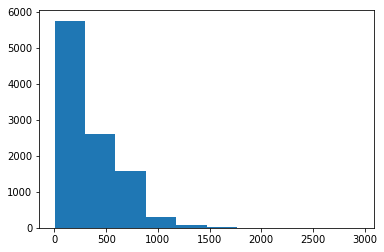

In [5]:
matplotlib.pyplot.hist(wordCount)
print('Distribution of Synopsis Word Counts')

### Here's what a plot synopsis might look like.  Even to a human (at least one unfamiliar with the movie), it might not be obvious whether a synopsis describes a comedy or a drama.  An interesting side project would be to assess what human error rates are for this task.

In [6]:
synNumber=random.randint(1,1000)
print(df['Title'].loc[synNumber])
print(df['Genre'].loc[synNumber])
print(df['Plot'].loc[synNumber])

Mr. Broadway
comedy
The plot involves a newspaper reporter (Ed Sullivan, aka "Mr. Broadway") gathering material for his column. The plot was patterned on a similar film by columnist Walter Winchell, Broadway Through a Keyhole (1933). The Sullivan film primarily serves as a vehicle for him to escort viewers to various trendy New York nightclubs to watch celebrities.[1]


1. # EDA for News Dataset

In [7]:
##Take roughly balanced sample of news dataset between comedy and non-comedy stories
newsDF['Comedy']=(newsDF['category']=='COMEDY')
news=pd.concat([newsDF[newsDF['Comedy']==False].sample(5000),newsDF[newsDF['Comedy']]],axis=0)
print('News Comedies: ',news['Comedy'].value_counts().values[0])
print('News Non-Comedies: ',news['Comedy'].value_counts().values[1])

wordCountNews=newsDF['short_description'].apply(lambda x: x.count(' '))
wordCountHeadline=newsDF['headline'].apply(lambda x: x.count(' '))

print("Mean number of words in synopsis: ",int(wordCountNews.mean()))
print("Standard deviation number of words in synopsis: ", int(wordCountNews.std()))
print()
print("Mean number of words in headline: ",int(wordCountHeadline.mean()))
print("Standard deviation number of words in headline: ", int(wordCountHeadline.std()))

News Comedies:  5175
News Non-Comedies:  5000
Mean number of words in synopsis:  18
Standard deviation number of words in synopsis:  14

Mean number of words in headline:  8
Standard deviation number of words in headline:  3


# 3. Text processing and vectorization
News descriptions are quite short, so concatenate with headlines to add information

In [8]:
news=news.reset_index()
news['Text']=news['short_description'].str.cat(news['headline'])
news['OriginalText']=news['Text']


Switching back to the movie dataset, stem each plot synopsis.  I don't stem the news articles because I don't use the news articles for the bag-of-words model, nor do I used stemmed versions for the neural net models.  Using stemmed words for those models did not improve performance.

In [9]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
df['StemmedPlot']=df['Plot'].str.split().apply(lambda x: ' '.join([stemmer.stem(y) for y in x]))


Make the both datasets lower-case and remove stop words

In [10]:
lower=news['Text'].str.lower()
noStops=removeStopWords(lower)
news['Text']=noStops

#Store Original Plot for later
df['OriginalPlot']=df['Plot']

lower=df['Plot'].str.lower()
cleaned=removeStopWords(lower)
df['Plot']=cleaned

Tokenize movie data and pad sequences to maximum length

In [11]:
##Using non-stemmed
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df['Plot']))
sequences = tokenizer.texts_to_sequences(list(df['Plot']))
maxLen=np.max([len(sequence) for sequence in sequences])
print("Maximum Length: ",maxLen)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxLen)

#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)


Maximum Length:  1536
Found 81642 unique tokens.
Shape of data tensor: (10343, 1536)


Tokenize movie data and pad sequences to maximum length **from movie data**

In [12]:

newstokenizer = Tokenizer()
newstokenizer.fit_on_texts(list(news['Text']))
newsSequences = newstokenizer.texts_to_sequences(list(news['Text']))
newsword_index = newstokenizer.word_index
print('Found %s unique tokens.' % len(newsword_index))
newsdata = pad_sequences(newsSequences, maxlen=maxLen)

#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', newsdata.shape)
#print('Shape of label tensor:', labels.shape)

Found 27846 unique tokens.
Shape of data tensor: (10175, 1536)


Quick sanity check to make sure that the tokenizer worked properly

In [13]:
##Sanity Check index is the word_index dictionary with keys reversed
sanityCheckIndex={v: k for k, v in tokenizer.word_index.items()}
print(sequences[500])
print(' '.join([sanityCheckIndex[wordIndex] for wordIndex in sequences[500]]))
print(data[500][0])
print(data[500][-1])
print(' '.join([sanityCheckIndex[wordIndex] for wordIndex in data[500] if wordIndex!=0 ]))

[2885, 51850, 63, 1291, 8497, 200, 1030, 3198, 7665, 14547, 2848, 26, 162, 740, 1394, 582, 16834, 701, 4471, 3198, 627, 844, 2276, 6538, 3608, 4705, 1457, 1032, 3608, 3198, 2885, 69, 903, 51851, 15978, 10, 414, 24, 903, 454, 768, 2885, 226, 2175, 16861, 414, 2885, 114, 4857, 1457, 6405, 184, 284, 15978, 8006, 8163, 903, 2506, 214, 1291, 6698, 22056, 726, 3198, 2739, 39, 634, 3187, 2741, 768, 3198, 237, 2030, 800, 2725, 2756, 86, 24, 2885, 265, 837, 15978, 1266, 335, 141, 15979, 3198, 22057, 1455, 1313, 676, 634, 903, 86, 2258, 2885, 3198, 51852, 36, 218, 100, 3008, 405, 743, 2885, 1291, 233, 181, 70, 50, 68, 274, 54, 116]
marion corsey's husband andrew conned small fortune vivian hepburn dedicates recovering money order so hides identity insinuates social circle vivian becoming secretary studies tactics employed sexy con artist employed vivian marion meets guy tarlow vivian's love interest however guy seems interested marion taking advantage guy's interest marion turns tables con artis

The above tokenizers will be used for the neural network models.  For the bag-of-words model, I use a TF-IDF DTM using the stemmed synopses created earlier

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfs = tfidf.fit_transform(df['StemmedPlot'])
print('Shape of TF-IDF matrix: ', tfs.T.shape)



Shape of TF-IDF matrix:  (66867, 10343)


Split the data into train and test sets.  Additionally, create separate training sets for training data enhanced with news data and training data consisting only of movie data

In [15]:
seed=random.randint(1,1000)
X_train, X_test, y_train, y_test = train_test_split(data, df['GenreID'], test_size=0.2, random_state=seed)
testIndices=y_test.index
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

y_train_small=y_train.copy()
X_train_small=X_train.copy()

y_train_add=to_categorical(news['Comedy'])
X_train_add=newsdata
X_train=np.concatenate([X_train,X_train_add],axis=0)
y_train=np.concatenate([y_train, y_train_add],axis=0)
print("X Train without news shape: ",X_train_small.shape)
print("Y train without news shape: ",y_train_small.shape)
print("X train with news shape: ",X_train.shape)
print("Y train with news shape: ",y_train.shape)
print("X test shape: ",X_test.shape)
print("Y test shape: ",y_test.shape)


X Train without news shape:  (8274, 1536)
Y train without news shape:  (8274, 2)
X train with news shape:  (18449, 1536)
Y train with news shape:  (18449, 2)
X test shape:  (2069, 1536)
Y test shape:  (2069, 2)


In [16]:
X_trainBag, X_testBag, y_trainBag, y_testBag = train_test_split(tfs, df['GenreID'], test_size=0.2, random_state=seed)
testIndicesBag=y_testBag.index
y_trainBag=to_categorical(y_trainBag)
y_testBag=to_categorical(y_testBag)
print("BoW X Train Shape: ",X_trainBag.shape)
print("BoW Y Train Shape: ",y_trainBag.shape)
print("BoW X Test Shape: ",X_testBag.shape)
print("BoW Y Test Shape: ",y_testBag.shape)


BoW X Train Shape:  (8274, 66867)
BoW Y Train Shape:  (8274, 2)
BoW X Test Shape:  (2069, 66867)
BoW Y Test Shape:  (2069, 2)


# 4.  Bag of Words Model
Use the TF-IDF matrix (split into training and test) from the pre-processing step to train a logistic regression binary classifier.

In [17]:
from keras import *
from keras.layers import Dense
from keras.utils import to_categorical
tf_input = Input(shape=(tfs.shape[1],), dtype='float32')
x=Dense(len(genres),activation='sigmoid')(tf_input)
bagOfWords = Model(tf_input, x)
bagOfWords.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

bagOfWords.fit(X_trainBag, y_trainBag, validation_data=(X_testBag, y_testBag),epochs=20, batch_size=128)


Train on 8274 samples, validate on 2069 samples
Epoch 1/20
8274/8274 [==============================] - 12s 1ms/step - loss: 0.6854 - acc: 0.5804 - val_loss: 0.6805 - val_acc: 0.5640
Epoch 2/20
8274/8274 [==============================] - 11s 1ms/step - loss: 0.6671 - acc: 0.5798 - val_loss: 0.6716 - val_acc: 0.5640
Epoch 3/20
8274/8274 [==============================] - 11s 1ms/step - loss: 0.6521 - acc: 0.5798 - val_loss: 0.6640 - val_acc: 0.5640
Epoch 4/20
8274/8274 [==============================] - 12s 1ms/step - loss: 0.6379 - acc: 0.5850 - val_loss: 0.6564 - val_acc: 0.5660
Epoch 5/20
8274/8274 [==============================] - 11s 1ms/step - loss: 0.6236 - acc: 0.6056 - val_loss: 0.6487 - val_acc: 0.5824
Epoch 6/20
8274/8274 [==============================] - 11s 1ms/step - loss: 0.6090 - acc: 0.6409 - val_loss: 0.6406 - val_acc: 0.5998
Epoch 7/20
8274/8274 [==============================] - 11s 1ms/step - loss: 0.5937 - acc: 0.6933 - val_loss: 0.6322 - val_acc: 0.6269
Epoch 8

# 5. GloVE embeddings
Load the GloVE 6B 100d word embeddings in hopes that they will enhance the accuracy and training speed of the neural network models.

In [18]:
embeddings={}
index=0
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt') as file:
    for embeddingLine in file:
        lineSplit=embeddingLine.split()
        coefs = np.asarray(lineSplit[1:], dtype='float32')
        embeddings[lineSplit[0]]=coefs
        index+=1



Map the GloVE embeddings to the data

In [19]:
embeddings_matrix=np.zeros((len(word_index)+1,len(embeddings['a'])))
for word,i in word_index.items():
    if word in embeddings:
        embeddings_matrix[i]=embeddings[word]



Quick check to make sure that the embeddings matrix is right

In [20]:
print('Word #2: ',sanityCheckIndex[2])
print('Index of him : ',word_index['him'])
print('Embbedding in embeddings list: ',embeddings['him'][:5])
print('Embedding in embeddings matrix: ',embeddings_matrix[2][:5])


Word #2:  him
Index of him :  2
Embbedding in embeddings list:  [ 0.042409 -0.52195   0.40389  -0.31683   0.015581]
Embedding in embeddings matrix:  [ 0.042409   -0.52195001  0.40389001 -0.31683001  0.015581  ]


Create Keras embedding layers to convert the texts to embeddings.  One uses Glove, the other doesn't.  I test models using both.

In [21]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            len(embeddings['a']),
                            weights=[embeddings_matrix],
                            input_length=maxLen,
                            trainable=False)
embedding_layerNoGlove = Embedding(len(word_index) + 1,
                            len(embeddings['a']),
                            weights=[embeddings_matrix],
                                   input_length=maxLen,
                            )


Check to make sure embedding layer does what it should be doing

In [22]:
sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
embeddingOnlyModel = Model(sequence_input, embedded_sequences)

print('Manual Embeddings Result: ',[list(embeddings[sanityCheckIndex[x]][:3]) if sanityCheckIndex[x] in embeddings else [0,0,0] for x in sequences[500] ][-5:])
##print(sequences[500])
##print([ sanityCheckIndex[l] for l in list(data[500]) if l>0 ])
##print([ sanityCheckIndex[l] for l in list(sequences[500]) if l>0 ])
print('Model Embeddings Result: ',embeddingOnlyModel.predict(np.array(data[500]).reshape(1,maxLen))[0,-5:,:3])
##print(embeddings_matrix[2][:5])


Manual Embeddings Result:  [[0.45009, 0.16062, 0.11566], [-0.53849, 0.55165, 0.55302], [0.002042, 0.23462, 0.56775], [-0.11619, 0.45447, -0.69216], [-0.18572, 0.30092, 0.36868]]
Model Embeddings Result:  [[ 0.45009   0.16062   0.11566 ]
 [-0.53849   0.55165   0.55302 ]
 [ 0.002042  0.23462   0.56775 ]
 [-0.11619   0.45447  -0.69216 ]
 [-0.18572   0.30092   0.36868 ]]


# 6. CNN Model
Start with a 3 layer CNN to predict the genre.  Note that here I am training the word encodings ourselves, rather than using the GloVE encodings

In [23]:
sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layerNoGlove(sequence_input)
x=Conv1D(128, 9, activation='relu')(embedded_sequences)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)
x = Flatten()(x)
x=Dense(128, activation='relu')(x)
x=Dense(len(genres),activation='softmax')(x)

noGloveCNN = Model(sequence_input, x)
noGloveCNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
noGloveCNN.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=2, batch_size=128)

Train on 18449 samples, validate on 2069 samples
Epoch 1/2
18449/18449 [==============================] - 327s 18ms/step - loss: 0.6907 - acc: 0.5366 - val_loss: 0.6564 - val_acc: 0.5916
Epoch 2/2
18449/18449 [==============================] - 326s 18ms/step - loss: 0.6505 - acc: 0.5741 - val_loss: 0.5947 - val_acc: 0.6844


Same as above, except using GloVE embeddings.  Trains faster, but no more accurate.

In [24]:
from keras.layers import Conv1D,MaxPooling1D,Dense,Flatten, Dropout, Bidirectional
sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x=Conv1D(128, 9, activation='relu')(embedded_sequences)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)

x = Flatten()(x)
x=Dense(128, activation='relu')(x)
x=Dense(len(genres),activation='softmax')(x)

model = Model(sequence_input, x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
X_train.shape
model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=2, batch_size=128)

Train on 18449 samples, validate on 2069 samples
Epoch 1/2
18449/18449 [==============================] - 251s 14ms/step - loss: 0.6906 - acc: 0.5346 - val_loss: 0.6584 - val_acc: 0.6254
Epoch 2/2
18449/18449 [==============================] - 250s 14ms/step - loss: 0.6576 - acc: 0.5662 - val_loss: 0.6149 - val_acc: 0.6834


Same as above except using only the movie data, without the additional news data

In [25]:

sequence_input = Input(shape=(maxLen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x=Conv1D(128, 9, activation='relu')(embedded_sequences)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)

x = Flatten()(x)
x=Dense(128, activation='relu')(x)
x=Dense(len(genres),activation='softmax')(x)

modelSmall = Model(sequence_input, x)
modelSmall.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
X_train.shape
modelSmall.fit(X_train_small, y_train_small, validation_data=(X_test, y_test),epochs=2, batch_size=128)

Train on 8274 samples, validate on 2069 samples
Epoch 1/2
8274/8274 [==============================] - 120s 15ms/step - loss: 0.6892 - acc: 0.5894 - val_loss: 0.6551 - val_acc: 0.6003
Epoch 2/2
8274/8274 [==============================] - 119s 14ms/step - loss: 0.6199 - acc: 0.6466 - val_loss: 0.6121 - val_acc: 0.6810


# 7.  LSTM-CNN model
Try adding an LSTM layer to the end of the CNN (starting with combined data and GloVE embeddings)

In [26]:

from keras.layers import LSTM, Dropout,Activation, Bidirectional
word_indices =Input(shape=(maxLen,), dtype='int32')
# Propagate sentence_indices through your embedding layer, you get back the embeddings
embeddingsLSTM = embedding_layer(word_indices)   

# Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
# Be careful, the returned output should be a batch of sequences.
x=Conv1D(128, 9, activation='relu')(embeddingsLSTM)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)

X =  LSTM(128,return_sequences=False)(x)
# Add dropout with a probability of 0.5
X = Dropout(.65)(X)
# Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
X = Dense(len(genres),activation='softmax')(X)
# Add a softmax activation
X = Activation('softmax')(X)
    # Create Model instance which converts sentence_indices into X.
LSTMmodel = Model(inputs = word_indices, outputs = X) 
LSTMmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTMmodel.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=2, batch_size=128)

Train on 18449 samples, validate on 2069 samples
Epoch 1/2
18449/18449 [==============================] - 253s 14ms/step - loss: 0.6912 - acc: 0.5277 - val_loss: 0.6713 - val_acc: 0.5640
Epoch 2/2
18449/18449 [==============================] - 250s 14ms/step - loss: 0.6717 - acc: 0.5588 - val_loss: 0.6141 - val_acc: 0.6767


Same as above, except with just the movie data

In [27]:
from keras.layers import LSTM, Dropout,Activation, Bidirectional
word_indices =Input(shape=(maxLen,), dtype='int32')
# Propagate sentence_indices through your embedding layer, you get back the embeddings
embeddingsLSTM = embedding_layer(word_indices)   

# Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
# Be careful, the returned output should be a batch of sequences.
x=Conv1D(128, 9, activation='relu')(embeddingsLSTM)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)
x=Conv1D(128, 9, activation='relu')(x)
x = Dropout(.4)(x)
x=MaxPooling1D(9)(x)

X =  LSTM(128,return_sequences=False)(x)
# Add dropout with a probability of 0.5
X = Dropout(.65)(X)
# Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
X = Dense(len(genres),activation='softmax')(X)
# Add a softmax activation
X = Activation('softmax')(X)
    # Create Model instance which converts sentence_indices into X.
LSTMmodelSmall = Model(inputs = word_indices, outputs = X) 
LSTMmodelSmall.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTMmodelSmall.fit(X_train_small, y_train_small, validation_data=(X_test, y_test),epochs=5, batch_size=128)

Train on 8274 samples, validate on 2069 samples
Epoch 1/5
8274/8274 [==============================] - 122s 15ms/step - loss: 0.6862 - acc: 0.5709 - val_loss: 0.6846 - val_acc: 0.5640
Epoch 2/5
8274/8274 [==============================] - 119s 14ms/step - loss: 0.6603 - acc: 0.6079 - val_loss: 0.6377 - val_acc: 0.6312
Epoch 3/5
8274/8274 [==============================] - 118s 14ms/step - loss: 0.6177 - acc: 0.6647 - val_loss: 0.6228 - val_acc: 0.6510
Epoch 4/5
8274/8274 [==============================] - 119s 14ms/step - loss: 0.6022 - acc: 0.6841 - val_loss: 0.6022 - val_acc: 0.6887
Epoch 5/5
8274/8274 [==============================] - 118s 14ms/step - loss: 0.5772 - acc: 0.7131 - val_loss: 0.6000 - val_acc: 0.6868


# 8 Analysis and Conclusion
Make test set predictions to compare and evaluate the models.

In [28]:
CNNpreds=model.predict(X_test)

In [29]:
LSTMpreds=LSTMmodel.predict(X_test)

In [30]:
noGloveCNNpreds=noGloveCNN.predict(X_test)

In [31]:
bagPreds=bagOfWords.predict(X_testBag)


In most train-test splits, ensembling the model predictions, weighted toward the BoW predictions, improves accuracy slightly.  But the accuracy improvement above the BoW model (the best single model) is negligible at best.  Final accuracy hovers around **77%**.  Not bad, considering that the task would probably not be straightforward even for humans.

In [32]:
avgPreds=np.average([bagPreds,LSTMpreds,CNNpreds],weights=[.8,.2,.2],axis=0)
avgPreds=bagPreds

withPreds=pd.concat([pd.DataFrame(avgPreds),df.loc[testIndices,['OriginalPlot','Genre','Title']].reset_index()],axis=1)
withPreds['Predicted Genre']=(withPreds[0]>withPreds[1]).replace(True,'drama').replace(False,'comedy')
accuracy=(withPreds['Predicted Genre']==withPreds['Genre']).mean()
print('Accuracy of final ensembled model: ',accuracy)

Accuracy of final ensembled model:  0.7752537457709038


Confusion matrix shows that the model errors are fairly balanced.

In [33]:
pd.pivot_table(withPreds,columns='Predicted Genre', index='Genre', aggfunc=len)['index']


Predicted Genre,comedy,drama
Genre,,
comedy,562,340
drama,125,1042


Take a look at the movies the ensemble model is most confident are comedies

In [34]:
for x in withPreds.sort_values(by=0)[['Title','OriginalPlot',0,'Genre']].head(3).iterrows():
    print(x[1].Title,x[1][0],x[1]['Genre'])
    print(x[1].OriginalPlot)
    print(' ')

Major League 0.052438296377658844 comedy
Former Las Vegas showgirl Rachel Phelps (Margaret Whitton) inherits the Cleveland Indians baseball team from her deceased husband, Donald. Phelps receives a lucrative offer to move the team to Miami, but she must first trigger the escape clause in the team's contract with the city of Cleveland. To do this, she must cause attendance at the games to fall below a certain level. She decides to replace existing players with aging veterans and inexperienced rookies in the hopes that a bad team will cause attendance to decline. They need to finish dead last to void the lease to move the team to Miami. Phelps hires Lou Brown, a manager for the Toledo Mud Hens, to manage the team.
During spring training in Tucson, Brown and veteran catcher Jake Taylor discover the new team has a number of interpersonal issues as well as their own struggles with the game. Problems include prima donna third baseman Roger Dorn, the weakening arm of veteran pitcher Eddie Har

Movies the ensemble model is most confident are not comedies.

In [35]:
for x in withPreds.sort_values(by=1)[['Title','OriginalPlot',0,'Genre']].head(3).iterrows():
    print(x[1].Title,x[1][0],x[1]['Genre'])
    print(x[1].OriginalPlot)
    print(' ')

Pressure 0.34172746539115906 drama
Anthony is a British, black teenager named who goes by the nickname of "Tony". Tony was born and raised in Britain while the rest of his family — his mother, father, and older brother — were born in Trinidad in the Caribbean. This affects the family members' viewpoints about the society they live in. Tony’s mother says they, as blacks, must work hard, mind their business and respect white people’s laws because the whites have the power. The film shows how the older generations are satisfied with living in a society ruled by the white English, which differs from the views of the younger generation. There is a disconnect between the way Tony feels about Britain and the way that his family feels, specifically his brother. Tony’s brother is active in the black power movement and is constantly discussing how blacks are treated as second-class citizens who are faced with racism in an unjust societal system. He stresses the idea of a collective effort on beh

Get the weights out of the Bag of Words model to see what words are most predictive of dramas and comedies

In [36]:
weights=bagOfWords.get_weights()[0][:,0]
mostDramatic=weights.argsort()[-10:][::-1]
leastDramatic=weights.argsort()[:10][::1]
index_to_words={v: k for k, v in tfidf.vocabulary_.items()}

In [37]:
print('Words most likely to indicate comedy: ', [index_to_words[x] for x in leastDramatic])

Words most likely to indicate comedy:  ['think', 'chase', 'plan', 'pretend', 'head', 'disguis', 'real', 'knock', 'date', 'manag']


In [38]:
print('Words most likely to indicate drama: ',[index_to_words[x] for x in mostDramatic])

Words most likely to indicate drama:  ['death', 'die', 'rape', 'kill', 'killed', 'injur', 'emot', 'life', 'grief', 'dies']


# Final Notes
After all that, none of the fancy machine learning techniques improved the relatively straightforward Bag of Words logistic regression.  All of the model architectures I tried were about 7% less accurate than the simple model, even when incorporating GloVE embeddings and additional training data from news articles. A reminder, perhaps, that complexity and cutting edge is not necessarily always better, especially in light of the interpretability of the Bag of Words model, highlighted by the above list of words associated with comedy and drama synopses.

# Predict Your Own - Just for Fun

In [39]:
def bowPredict(syn):
    noStops=removeStopWords([syn])
    stemmed=' '.join([stemmer.stem(x) for x in noStops[0].split() ])
    mat=tfidf.transform([stemmed])
    preds=bagOfWords.predict(mat)
    if preds[0][0]>preds[0][1]: return 'comedy'
    return 'drama'

In [40]:
bowPredict("United States Naval Aviator LT Pete ‘Maverick’ Mitchell and his Radar Intercept Officer LTJG Nick ‘Goose’ Bradshaw fly the F-14A Tomcat aboard USS Enterprise (CVN-65). During an interception with two hostile MiG-28aircraft (portrayed by a Northrop F-5), Maverick gets missile lock on one, while the other hostile aircraft locks onto Maverick's wingman, Cougar. While Maverick drives off the remaining MiG-28, Cougar is too shaken to land, and Maverick, defying orders, shepherds him back to the carrier. Cougar gives up his wings, citing his newborn child that he has never seen. Despite his dislike for Maverick's recklessness, CAG ’Stinger’ sends him and Goose to attend Topgun,[6] the Naval Fighter Weapons School at Naval Air Station Miramar.At a bar the day before Topgun starts, Maverick, assisted by Goose, unsuccessfully approaches a woman. He learns the next day that she is Charlotte ‘Charlie’ Blackwood, an astrophysicist and civilian Topgun instructor. She becomes interested in Maverick upon learning of his inverted maneuver with the MiG-28, which disproves US intelligence on the enemy aircraft's performance. During Maverick's first training sortie he defeats instructor LCDR Rick ‘Jester’ Heatherly but through reckless flying breaks two rules of engagement and is reprimanded by chief instructor CDR Mike ‘Viper’ Metcalf. Maverick also becomes a rival to top student LT Tom ‘Iceman’ Kazansky, who considers Maverick's flying ‘dangerous.’ Charlie also objects to Maverick's aggressive tactics but eventually admits that she admires his flying and omitted it from her reports to hide her feelings for him, and the two begin a romantic relationship. During a training sortie, Maverick abandons his wingman ‘Hollywood’ to chase Viper, but is defeated when Viper maneuvers Maverick into a position from which his wingman Jester can shoot down Maverick from behind, demonstrating the value of teamwork over individual prowess. Maverick and Iceman, now direct competitors for the Topgun Trophy, chase an A-4 in a later training engagement. Maverick pressures Iceman to break off his engagement so he can shoot it down, but Maverick's F-14 flies through the jet wash of Iceman's aircraft and suffers a flameout of both engines, going into an unrecoverable flat spin. Maverick and Goose eject, but Goose hits the jettisoned aircraft canopy head-first and is killed. Although the board of inquiry clears Maverick of responsibility for Goose's death, he is overcome by guilt and his flying skill diminishes. Charlie and others attempt to console him, but Maverick considers retiring. He seeks advice from Viper, who reveals that he served with Maverick's father Duke Mitchell on the USS Oriskany and was in the air battle in which Mitchell was killed. Contrary to official reports which faulted Mitchell, Viper reveals classified information that proves Mitchell died heroically, and informs Maverick that he can succeed if he can regain his self-confidence. Maverick chooses to graduate, though Iceman wins the Top Gun Trophy. During the graduation party, Viper calls in the newly graduated aviators with the orders to deploy. Iceman, Hollywood, and Maverick are ordered to immediately return to Enterprise to deal with a ‘crisis situation’, providing air support for the rescue of a stricken ship that has drifted into hostile waters. Maverick and Merlin (Cougar's former RIO) are assigned as back-up for F-14s flown by Iceman and Hollywood, despite Iceman's reservations over Maverick's state of mind. The subsequent hostile engagement with six MiGs sees Hollywood shot down; Maverick is scrambled alone due to a catapult failure and nearly retreats after encountering circumstances similar to those that caused Goose's death. Upon finally rejoining Iceman, Maverick shoots down three MiGs, and Iceman one, forcing the other two to flee. Upon their triumphant return to Enterprise, Iceman and Maverick express newfound respect for each other. Offered any assignment he chooses, Maverick decides to return to Topgun as an instructor. At a bar in Miramar, Maverick and Charlie reunite.")


'comedy'